In [1]:
#Setup

min_date = '2022-09-01' # Start time
max_date = '2023-10-01' # End time
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"
VH_file = "ThuanHoa/ThuanHoa_VH.tif"
VV_file = "ThuanHoa/ThuanHoa_VV.tif"
min_longitude, max_longitude = (105.86575, 105.94120)
min_latitude, max_latitude = (9.65070, 9.69850)
product = 's2_l2a'

In [2]:
%%time
# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Common imports and settings
import os, sys
os.environ['USE_PYGEOS'] = '0'
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr

# Datacube
import datacube
from datacube.utils.rio import configure_s3_access
from datacube.utils import masking
from datacube.utils.cog import write_cog
# https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
from dea_tools.plotting import display_map, rgb
from dea_tools.datahandling import mostcommon_crs

# EASI defaults
easinotebooksrepo = '/home/jovyan/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import EasiDefaults, xarray_object_size, notebook_utils, unset_cachingproxy
from easi_tools.load_s2l2a import load_s2l2a_with_offset

# Data tools
import numpy as np
from datetime import datetime

# Datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_masking.py
from odc.algo import xr_reproject   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_warp.py
from datacube.utils.geometry import GeoBox, box  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/geometry/_base.py

# Holoviews, Datashader and Bokeh
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
from utils import load_data_geo
import rasterio
import os
import rioxarray
# import geoviews as gv
# from holoviews.operation.datashader import rasterize
hv.extension('bokeh', logo=False)

from deafrica_tools.bandindices import calculate_indices
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import joblib

CPU times: user 7.68 s, sys: 1.45 s, total: 9.13 s
Wall time: 7.83 s


In [3]:

# Dask gateway

cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
client

Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.cfb43721a0d54558b483f3df70db42b4/status,


In [4]:
dc = datacube.Datacube()

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [5]:
query = {
    'product': product,                     # Product name
    'x': (min_longitude, max_longitude),    # "x" axis bounds
    'y': (min_latitude, max_latitude),      # "y" axis bounds
    'time': (min_date, max_date),           # Any parsable date strings
}


In [6]:
# Most common CRS
native_crs = notebook_utils.mostcommon_crs(dc, query)
print(f'Most common native CRS: {native_crs}')

Most common native CRS: EPSG:32648


In [7]:
measurements = ['blue', 'green', 'red', 'nir', 'scl']

load_params = {
    'measurements': measurements,                   # Selected measurement or alias names
    'output_crs': native_crs,                       # Target EPSG code
    'resolution': (-10, 10),                        # Target resolution
    'group_by': 'solar_day',                        # Scene grouping
    'dask_chunks': {'x': 2048, 'y': 2048},          # Dask chunks
}

In [8]:
%%time
# The replacement "dc.load()" function for this product
data = load_s2l2a_with_offset(
    dc,
    query | load_params   # Combine the two dicts that contain our search and load parameters
)

# This line prints the total size of the dataset hat was loaded
notebook_utils.heading(notebook_utils.xarray_object_size(data))

display(data)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

CPU times: user 614 ms, sys: 13.8 ms, total: 627 ms
Wall time: 670 ms


In [9]:
flag_name = 'scl'
flag_desc = masking.describe_variable_flags(data[flag_name])  # Pandas dataframe
display(flag_desc)
display(flag_desc.loc['qa'].values[1])

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

In [11]:
# Create a "data quality" Mask layer
flags_def = flag_desc.loc['qa'].values[1]
good_pixel_flags = [flags_def[str(i)] for i in [2, 4, 5, 6]]  # To pass strings to enum_to_bool()

# enum_to_bool calculates the pixel-wise "or" of each set of pixels given by good_pixel_flags
# 1 = good data
# 0 = "bad" data

good_pixel_mask = enum_to_bool(data[flag_name], good_pixel_flags)  # -> DataArray
# display(good_pixel_mask)  # Type: bool

In [12]:
data_layer_names = [x for x in data.data_vars if x != 'scl']
rs = []
for layer_name in data_layer_names:
    # Apply valid mask (calculated above) and good pixel mask
    # layer = data[[layer_name]].where(valid_mask[layer_name] & good_pixel_mask)
    layer = data[[layer_name]].where(good_pixel_mask)
    rs.append(layer)
    
# Calculate intermediate result
result = xr.merge(rs).persist()

In [16]:
from dask.distributed import wait, progress

progress(result)

VBox()

### Calculate NDVI based on monthly average

In [17]:
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
average_ndvi = ndvi.resample(time='1M').mean().persist()  ## tính mean cho từng tháng -> time = 13
average_ndvi  # DataArray

<xarray.DataArray 'NDVI' (time: 13, y: 532, x: 830)>
dask.array<stack, shape=(13, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30 2022-10-31 ... 2023-09-30

### Filled with Nan value

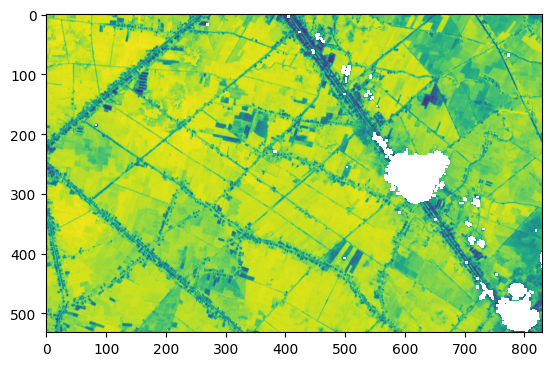

In [21]:
average_ndvi = average_ndvi.compute()
plt.imshow(average_ndvi.isel(time=5))

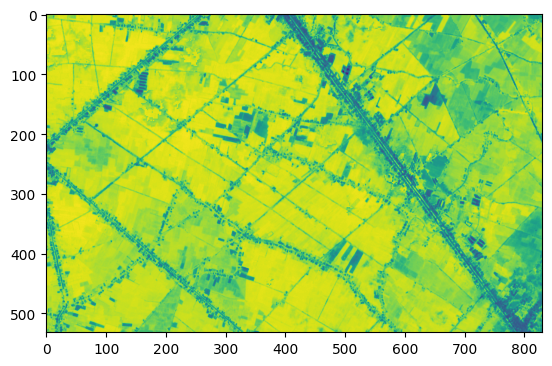

In [22]:
filled_ds = average_ndvi.bfill(dim='time')
filled_ds = filled_ds.ffill(dim='time')
plt.imshow(filled_ds.isel(time=5))

### Load VH, VV

In [23]:
dsvv = rioxarray.open_rasterio(VV_file)
dsvh = rioxarray.open_rasterio(VH_file)

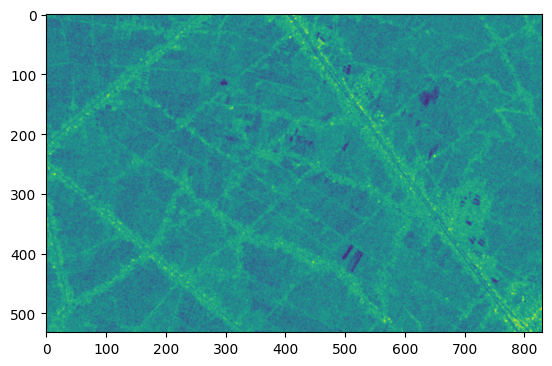

In [24]:
plt.imshow(dsvh.isel(band=5))

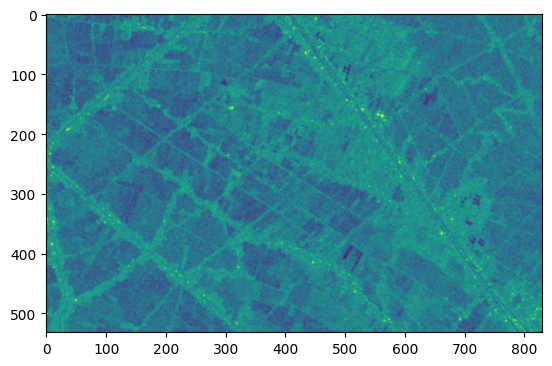

In [25]:
plt.imshow(dsvv.isel(band=5))

### Load training model and predict

In [26]:
import joblib
dir_save_model = "model_train"

data_predict = []
for i in range(filled_ds.shape[1]):
    ndvi_tmp = filled_ds.isel(y=i).values
    vh_data = dsvh.sel(y=filled_ds.y.values[i], method='nearest').values
    vv_data = dsvv.sel(y=filled_ds.y.values[i], method='nearest').values
    all_tmp = np.concatenate((ndvi_tmp, vh_data, vv_data), axis=0)
    data_predict.extend(all_tmp.T)


loaded_model = joblib.load(os.path.join(dir_save_model, "model.joblib"))
y_pred = loaded_model.predict(data_predict)
final_label = y_pred.reshape(filled_ds.y.shape[0], filled_ds.x.shape[0])

### Convert array result to xarray result

In [27]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
import rioxarray

final_xarray_save = xr.DataArray(final_label, dims=("y", "x"))
final_xarray_save = final_xarray_save.rio.write_crs(data.rio.crs)

x_values = average_ndvi.x.values
y_values = average_ndvi.y.values

data_array = xr.DataArray(final_xarray_save,
                          coords={'x': x_values, 'y': y_values},
                          dims=['y', 'x'])
data_array = data_array.rio.write_crs(average_ndvi.rio.crs)

### Load shape file Thuan Hoa

In [28]:
from shapely.geometry import Point, Polygon
import geopandas as gpd


gdf = gpd.read_file(thuanhoa_path)
gdf = gdf.to_crs(average_ndvi.rio.crs)
polygon_coords = list(gdf.geometry.values[0].exterior.coords)
polygon_coordinates = [(x, y) for x, y in polygon_coords]

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [polygon_coordinates]
    }
]

<Axes: >

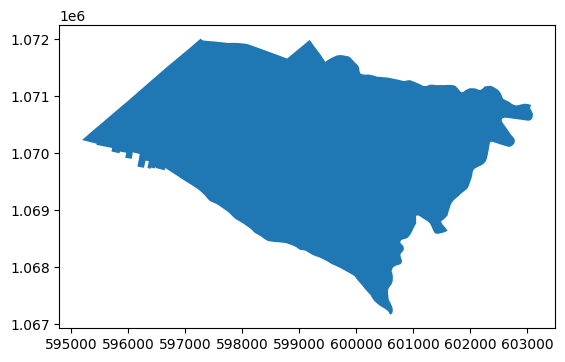

In [29]:
gdf.geometry.plot()

### Define color and label

In [30]:
from matplotlib.colors import ListedColormap
## label color
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

/tmp/ipykernel_930/3955241061.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


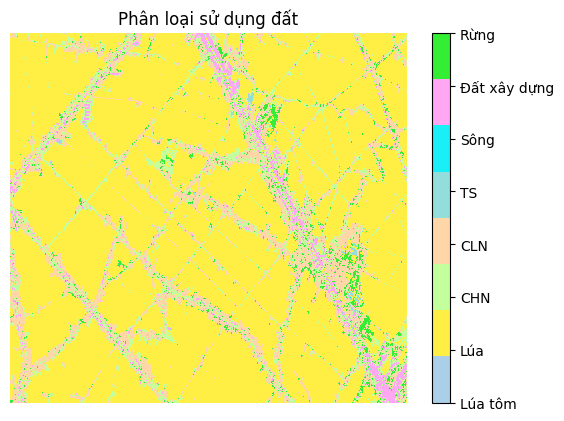

In [31]:
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

### Crop the result according to the Thuan Hoa boundary

In [32]:
region_result = data_array.rio.clip(geometries, data_array.rio.crs, drop=False)
region_result = region_result.where(region_result >= 0, float('nan'))

/tmp/ipykernel_930/2087183616.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


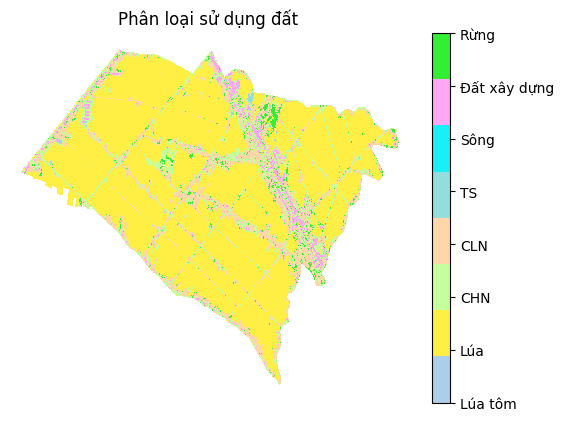

In [33]:
cmap = ListedColormap(colors)
img = region_result.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [42]:
region_result.rio.to_raster("KetQuaPhanLoaiDat.tif")

In [57]:
client.close()
cluster.close()